Adapted from [NIRPY](https://nirpyresearch.com/partial-least-squares-regression-python/)


In [11]:
from sys import stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

## Import data 
The data is composed of 50 NIR spectra of fresh peaches. Each spectrum has a corresponding Brix value (the response) associated with it. Finally, each spectrum is taken over 600 wavelength points, from 1100 nm to 2300 nm in steps of 2 nm. The data is available for download [here](https://github.com/nevernervous78/nirpyresearch/tree/master/data).

In [12]:
data = pd.read_csv('./data/peach_spectra_brix.csv')
# Get reference values
y = data['Brix'].values
# Get spectra
X = data.drop(['Brix'], axis=1).values
# Get wavelengths
wl = np.arange(1100,2300,2)

Pre-processing steps. In our case just a second derivative + smoothing will do.

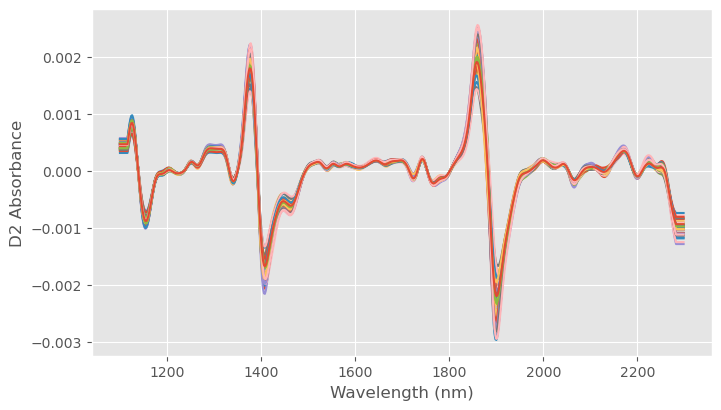

In [13]:
# Calculate second derivative
X2 = savgol_filter(X, 17, polyorder = 2,deriv=2)

# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

Here's the main function. It first runs a loop over the number of PLS components and calculate the MSE of prediction. Secondly, it seeks the number of components that minimises the MSE and uses that value to run a PLS again. The second time around, a whole bunch of metrics is calculated and printed. 

In [14]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):

    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''

    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)

    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')

        plt.show()

    return

Now let's run this function by setting the maximum number of components to 40. The second plot is the actual regression figure, including the metrics for the prediction.

10% completed

100% completed
Suggested number of components:  7



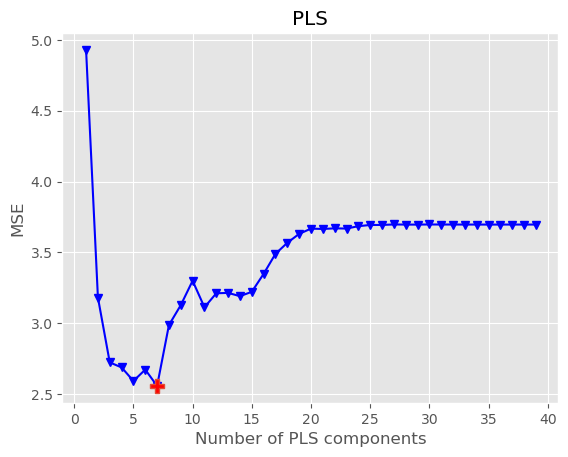

R2 calib: 0.859
R2 CV: 0.451
MSE calib: 0.657
MSE CV: 2.558


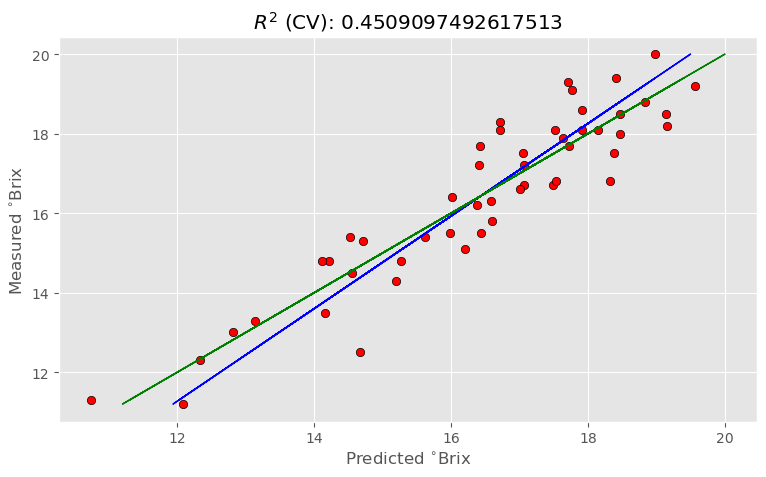

In [15]:
optimise_pls_cv(X2,y, 40, plot_components=True)